# Data Analysis of Movies by Rating Relative to Age

In [454]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd
import re

In [455]:
 InteractiveShell.ast_node_interactivity = "all" #Pretty-prints output function calls without need for print()

In [456]:
# Data source: https://grouplens.org/datasets/movielens/20m/
# Successfully matched MD5 checksum with reference provided (data verified)

movies_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/movies.csv')
ratings_mstr = pd.read_csv('/Users/Levient/Movie_Ratings/ml-20m/ratings.csv')

movies_mstr.head()
ratings_mstr.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [499]:
# Reusable split_column function splits the genres column. Returns a new df containing one new row for each genre.

genre_values = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']

def split_column(df, column, genre_values, sep = '|'):
    indices = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        for value in values:
            indices.append(i)
            new_values.append(value)
    new_df = df.iloc[indices, :].copy()
    new_df[column] = pd.Categorical(new_values, categories=genre_values)
    return new_df

movie_genres = split_column(movies_mstr, 'genres', genre_values)

movie_genres.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children
1,2,Jumanji (1995),Fantasy
2,3,Grumpier Old Men (1995),Comedy
2,3,Grumpier Old Men (1995),Romance


In [458]:
# All rows for 'movieId' and 'rating'

ratings = ratings_mstr[['movieId', 'rating']]
movies = movies_mstr[['movieId', 'title']]

ratings.head()
movies.head()

,movieId,rating
0,2,3.5
1,29,3.5
2,32,3.5
3,47,3.5
4,50,3.5


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [459]:
# Average all ratings per movie and add 'average' column

# The below ratings.loc function yields a 'chained_assignment' warning (not an error), despite use of df.loc[]. 
# The issue should probably be revisited: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

pd.options.mode.chained_assignment = None  # default='warn'

ratings.loc[:,'average'] = ratings.groupby('movieId')['rating'].transform('mean')

print('Average Ratings for All Movies')
ratings.head()

Average Ratings for All Movies


,movieId,rating,average
0,2,3.5,3.211977
1,29,3.5,3.952230
2,32,3.5,3.898055
3,47,3.5,4.053493
4,50,3.5,4.334372


In [460]:
# Remove duplicate ratings rows from ratings, drop rating column

print('Before\n', ratings.shape)

average_ratings = ratings.drop_duplicates(subset=['movieId', 'average']).drop(columns=['rating'])

print('After\n', average_ratings.shape)
print('Total movies\n', movies.shape)
print('Averages')
average_ratings.head()

# Issue to explore: There are more movies than there are average reviews. 

Before
 (20000263, 3)
After
 (26744, 2)
Total movies
 (27278, 2)
Averages


,movieId,average
0,2,3.211977
1,29,3.952230
2,32,3.898055
3,47,4.053493
4,50,4.334372


Median of Average Ratings
 3.601982097186701 
Mean of Average Ratings
 3.5255285642995635


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14bc45208>]],
      dtype=object)

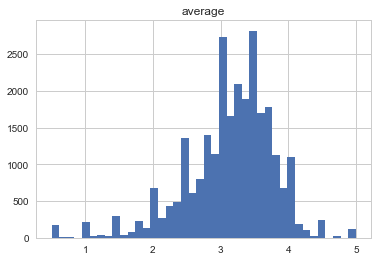

In [461]:
# Find median (and mean) of all ratings

ratings_median = ratings['average'].median()
ratings_mean = ratings['average'].mean()

print('Median of Average Ratings\n', ratings_median, '\nMean of Average Ratings\n', ratings_mean)
average_ratings.hist(bins=40, column=['average'])

In [509]:
# The classify_age function extracts a year in parens from 'title(year)' and returns a string (e.g. 'old') 

def classify_age(row):
    year = extract_year(row)
    return assign_age(year)

def extract_year(row):
    year_in_parens = re.compile('(?<=\()(\d{4})(?=\))')
    result = year_in_parens.search(row['title'])
    if result:
        return result.group(0)
    else: 
        return None

def assign_age(year):
    if year == None:
        return 'Unknown'
    year = dt.datetime(int(year), 1, 1)
    if year < dt.datetime(1970, 1, 1):
        return 'old'
    elif year < dt.datetime(1990, 1, 1):
        return 'medium'
    else:
        return 'new'

In [514]:
# Applying classify_age returns a new column 'age' with 4 classes: 'old', 'medium', 'new', 'unknown'
# Using categorical data for ease of sorting/visuzlizing

age_categories = ['new', 'medium', 'old']
ages = movies.apply(classify_age, axis=1)

movies['age'] = pd.Categorical(ages, categories=age_categories, ordered=True)

movies.head(5)

,movieId,title,age
0,1,Toy Story (1995),new
1,2,Jumanji (1995),new
2,3,Grumpier Old Men (1995),new
3,4,Waiting to Exhale (1995),new
4,5,Father of the Bride Part II (1995),new


Totals Counts of Each Age
 age
new       17118
medium     4674
old        5464
Name: title, dtype: int64

Percentages of Each Age
 age
new       64.006880
medium    17.476817
old       20.430751
Name: title, dtype: float64


KeyError: "['title'] not in index"

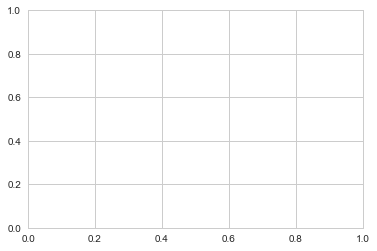

In [517]:
# Calculate number and percentage of each age

age_counts = movies.groupby('age')['title'].count()
percentages = age_counts.groupby(level=0).apply(lambda x: 100 * x / 26744)

print('Totals Counts of Each Age\n', age_counts)
print('\nPercentages of Each Age\n', percentages)

In [512]:
# Prepare to merge data by dropping title from movie_genres

genres = movie_genres.drop(['title'], axis=1)

# Inner join movies, ratings and genres on 'movieId'

movie_ratings = pd.merge(movies, average_ratings, on='movieId')
movie_genre_ratings = pd.merge(movie_ratings, genres, on='movieId')

movie_ratings.head()
movie_genre_ratings.tail()

,movieId,title,age,average
0,1,Toy Story (1995),new,3.921240
1,2,Jumanji (1995),new,3.211977
2,3,Grumpier Old Men (1995),new,3.151040
3,4,Waiting to Exhale (1995),new,2.861393
4,5,Father of the Bride Part II (1995),new,3.064592


,movieId,title,age,average,genres
53414,131258,The Pirates (2014),new,2.5,Adventure
53415,131260,Rentun Ruusu (2001),new,3.0,(no genres listed)
53416,131262,Innocence (2014),new,4.0,Adventure
53417,131262,Innocence (2014),new,4.0,Fantasy
53418,131262,Innocence (2014),new,4.0,Horror


In [479]:
# Sorting movies by average rating

movie_ratings = movie_ratings.sort_values(by=['average'], ascending=False)

movie_ratings.head()
movie_ratings.tail()

,movieId,title,age,average
19152,95517,"Barchester Chronicles, The (1982)",medium,5.0
21842,105846,Only Daughter (2013),new,5.0
17703,89133,Boys (Drenge) (1977),medium,5.0
21656,105187,Linotype: The Film (2012),new,5.0
21658,105191,Rocaterrania (2009),new,5.0


,movieId,title,age,average
26465,129784,Xuxa in Crystal Moon (1990),new,0.5
18534,92479,Kisses for My President (1964),old,0.5
26475,129834,Tom and Jerry: The Lost Dragon (2014),new,0.5
24207,115631,Alone for Christmas (2013),new,0.5
25043,119909,Sharpe's Eagle (1993),new,0.5


In [467]:
print('Length of Total Movie Ratings List\n', movie_ratings.shape)

# Top 20 percent
best = movie_ratings.iloc[:5349,:]
best_median = best["average"].median()
print('\nBest 20 percent (Median:', round(best_median, 2), ')\n', best.shape) 
best.head()

# Middle 20 percent
ok = movie_ratings.iloc[10697:16047,:]
ok_median = ok["average"].median()
print('\nMiddle 20 percent (Median:', round(ok_median, 2), ')\n', ok.shape)
ok.tail()

# Worst 20 percent
worst = movie_ratings.iloc[21395:,:]
worst_median = worst["average"].median()
print('\nWorst 20 percent (Median:', round(worst_median, 2), ')\n', worst.shape)
worst.tail()

Length of Total Movie Ratings List
 (26744, 4)

Best 20 percent (Median: 3.85 )
 (5349, 4)


,movieId,title,age,average
19152,95517,"Barchester Chronicles, The (1982)",medium,5.0
21842,105846,Only Daughter (2013),new,5.0
17703,89133,Boys (Drenge) (1977),medium,5.0
21656,105187,Linotype: The Film (2012),new,5.0
21658,105191,Rocaterrania (2009),new,5.0



Middle 20 percent (Median: 3.24 )
 (5350, 4)


,movieId,title,age,average
248,251,"Hunted, The (1995)",new,3.050258
2167,2252,Hero (1992),new,3.050031
21239,103651,Tai Chi Hero (2012),new,3.050000
9599,30890,"Keys to the House, The (Chiavi di casa, Le) (2...",new,3.050000
18856,94061,Madhouse (1974),medium,3.050000



Worst 20 percent (Median: 2.3 )
 (5349, 4)


,movieId,title,age,average
26465,129784,Xuxa in Crystal Moon (1990),new,0.5
18534,92479,Kisses for My President (1964),old,0.5
26475,129834,Tom and Jerry: The Lost Dragon (2014),new,0.5
24207,115631,Alone for Christmas (2013),new,0.5
25043,119909,Sharpe's Eagle (1993),new,0.5


In [468]:
# Check for null values in our dataframe
movie_ratings.isnull().values.any()

False

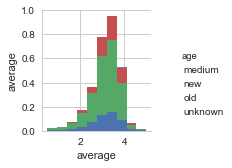

In [469]:
# Create the default pairplot
sns.pairplot(movie_ratings, vars=['average'], hue='age')

In [470]:
# Setting up basic classification prediction
# Extract 55 percent of our dataset randomly, from which to predict outcomes of remaining 45 percent

data_array = movie_ratings.values
np.random.shuffle(data_array)

X_learning = data_array[:14709][:,3]
Y_learning = data_array[:14709][:,2]

# "Teach" our machine (SVC) about the relationships between 'average' and 'age'
# (but first we need to reshape our X np_array into a 1-D array)

svc = SVC()
svc.fit(X_learning.reshape(-1, 1), Y_learning)

# Use the remaining 45 percent of our data as test data
X = data_array[-12035:][:,3]
Y = data_array[-12035:][:,2]

predictions = svc.predict(X.reshape(-1, 1))

print("Predicted Results:", predictions)
print("\nActual Results:", Y)
print("\nAccuracy rating:  %f" % (accuracy_score(Y, predictions)))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Predicted Results: ['new' 'new' 'new' ... 'new' 'new' 'new']

Actual Results: ['old' 'new' 'medium' ... 'new' 'medium' 'new']

Accuracy rating:  0.631491


In [471]:
# print(confusion_matrix(Y, predictions))
print(classification_report(Y, predictions))

             precision    recall  f1-score   support

     medium       0.00      0.00      0.00      2083
        new       0.63      1.00      0.77      7600
        old       0.00      0.00      0.00      2339
    unknown       0.00      0.00      0.00        13

avg / total       0.40      0.63      0.49     12035



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
